In [1]:
import pandas as pd
import numpy as np
from scipy.linalg import sqrtm
from sklearn.metrics import accuracy_score
import time
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import warnings
warnings.filterwarnings("ignore")
from scipy.spatial.distance import pdist,squareform,euclidean
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)

np.random.seed(123)

In [2]:
def similarity_func(u, v):
    '''
    Auxiliary function for similarity matrix construction.
    
    Attributes:
    ---
    u, v: ndarray
        Arrays of size (1xc), c is the number of classes.
    
    Returns:
    ---
    Gaussian kernel distance between the observations.
    '''
    return np.exp(-euclidean(u,v) ** 2 / 2)

In [3]:
def DNC(X, n_classes, n_steps=100, tol=1e-5):
    '''
    Implementation of Direct Normalized Cut (Algorithm 1) from the article.
    
    Attributes:
    ---
    X: ndarray
        Matrix (dxn), d is the number of features, n is the number of observations.
    n_classes: int
        Number of clusters.
    n_steps: int
        Number of iterations.
    tol: float
        Precision of the algorithm.
    
    Returns:
    ---
    Y: ndarray
         Matrix (nxc) with predicted clusters.
    '''
    
    A = squareform(pdist(X, similarity_func))
                              
    D_A = np.diag(A.sum(axis=1))
    D_A_inv_0_5 = np.diag(np.power(A.sum(axis=1), -0.5))
    D_A_0_5 = np.diag(np.power(A.sum(axis=1), 0.5))
    
    M = D_A_inv_0_5 @ A @ D_A_inv_0_5 + np.eye(A.shape[0])
    
    for i in range(0, 100):
        try:
            M += i*np.eye(A.shape[0])
            np.linalg.cholesky(M)
            print("Matrix is fine")
            break
        except:
            print("finding i")
        pass
    
    Y = np.random.rand(A.shape[0], n_classes)
    trace_max = np.array([])
    n_iter = 0
    
    while n_iter < n_steps:
        G = M @ D_A_0_5 @ Y @ sqrtm(np.linalg.pinv((Y.T @ D_A @ Y)))
        s_l = np.zeros_like(Y)
        for i in range(Y.shape[0]):
            for j in range(Y.shape[1]):
                ft = (Y[:, j]).T @ D_A_0_5 @ G[:, j]
                st = (Y[:, j]).T @ D_A @ Y[:, j]
                s_l[i, j] = (ft + G[i][j] * D_A_0_5[i][i]*(1-Y[i][j]))/np.sqrt(st + D_A[i][i]*(1-Y[i][j])) - (ft - Y[i][j]*D_A_0_5[i][i]*G[i][j])/np.sqrt(st - D_A[i][i]*Y[i][j])
                
        Y_new = np.zeros_like(Y)
        Y_new[np.arange(len(s_l)), s_l.argmax(1)] = 1
        Y = Y_new.copy()
              
        trace_max = np.append(trace_max, np.trace((D_A_0_5 @ Y @ sqrtm(np.linalg.pinv((Y.T @ D_A @ Y)))).T @ G))
        n_iter += 1
    
        if n_iter > 1:
            if np.linalg.norm(trace_max[-1] - trace_max[-2]) < tol:
                break
            
    return Y

In [4]:
def accuracy(clusters_labels, y_true):
    '''
    Function for measuring accuracy of clusterization.
    
    Attributes:
    ---
    clusters_labels: ndarray
        Predicted labels, size: (1xc).
    y_true: ndarray
        True labels, size: (1xc).
    
    Returns:
    ---
    accur: float
        Accuracy of clusterization.
    '''
    clusters = np.unique(clusters_labels)
    y_pred = np.empty(len(y_true))
    
    for cluster in clusters:
        mask_cluster = clusters_labels == cluster
        mean_pred = np.bincount(y_true[mask_cluster]).argmax()
        y_pred[mask_cluster] = mean_pred
    accur = accuracy_score(y_true, y_pred)
    return accur

Matrix is fine


0.45

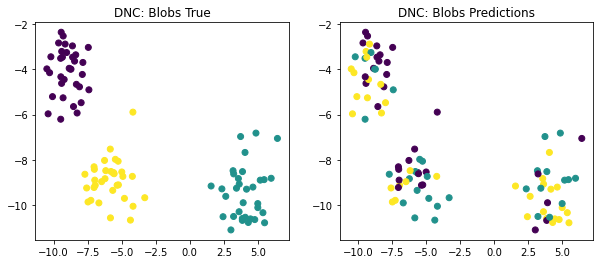

In [5]:
X, y = make_blobs(random_state=21)
pred = DNC(X, 3,  100, 1e-5)
fig, ax = plt.subplots(1, 2, figsize = (10, 4))
ax[0].scatter(X[:, 0], X[:, 1], c = y)
ax[0].set_title('DNC: Blobs True')
ax[1].scatter(X[:, 0], X[:, 1], c = np.argmax(pred, axis = 1))
ax[1].set_title('DNC: Blobs Predictions');

predictions = np.array([])
for i in range(pred.shape[0]):
    predictions = np.append(predictions, np.argmax(pred[i,:]))

accuracy(predictions, y)

* Isolet5 Dataset ($1559 \times 617$):

In [6]:
data = pd.read_csv("C:/Users/Yuliya/Downloads/isolet5.data", header=None)

In [7]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

In [8]:
start = time.time()
pred = DNC(X, 26)
print(time.time() - start)

Matrix is fine
673.9681901931763


In [9]:
predictions = np.array([])
for i in range(pred.shape[0]):
    predictions = np.append(predictions, np.argmax(pred[i,:]))

In [10]:
accuracy(predictions, y)

0.1334188582424631

* Set number of clusters to be $13$:

In [11]:
start = time.time()
pred = DNC(X, 13)
print(time.time() - start)

Matrix is fine
430.7332139015198


In [12]:
predictions = np.array([])
for i in range(pred.shape[0]):
    predictions = np.append(predictions, np.argmax(pred[i,:]))
accuracy(predictions, y)

0.0949326491340603

* Set number of clusters to be $30$:

In [13]:
start = time.time()
pred = DNC(X, 30)
print(time.time() - start)

Matrix is fine
652.1956553459167


In [14]:
predictions = np.array([])
for i in range(pred.shape[0]):
    predictions = np.append(predictions, np.argmax(pred[i,:]))
accuracy(predictions, y)

0.13662604233483003

* Segment Dataset ($2310 \times 21$):

In [19]:
segments = pd.read_csv("C:/Users/Yuliya/Downloads/segments.csv")

In [20]:
y = np.array(segments["class"])
X = segments.drop(["class"], axis=1)
X = np.array(X)

In [21]:
start = time.time()
pred = DNC(X, 7, 10)
print(time.time() - start)

Matrix is fine
841.2778205871582


In [22]:
predictions = np.array([])
for i in range(pred.shape[0]):
    predictions = np.append(predictions, np.argmax(pred[i,:]))
accuracy(predictions, y)

0.14285714285714285

* Set number of clusters to be $3$:

In [23]:
start = time.time()
pred = DNC(X, 3, 10)
print(time.time() - start)

Matrix is fine
413.2270333766937


In [24]:
predictions = np.array([])
for i in range(pred.shape[0]):
    predictions = np.append(predictions, np.argmax(pred[i,:]))
accuracy(predictions, y)

0.14285714285714285

* Set number of clusters to be $10$:

In [25]:
start = time.time()
pred = DNC(X, 10, 10)
print(time.time() - start)

Matrix is fine
1202.0342786312103


In [26]:
predictions = np.array([])
for i in range(pred.shape[0]):
    predictions = np.append(predictions, np.argmax(pred[i,:]))
accuracy(predictions, y)

0.14285714285714285

**Glass Data Set**

In [27]:
glass = pd.read_csv("C:/Users/Yuliya/Downloads/glass_processed.csv")

In [28]:
y = glass["target"]
X = glass.iloc[:, :-1]

In [29]:
start = time.time()
pred = DNC(X, 6)
print(time.time() - start)

Matrix is fine
1.329927682876587


In [30]:
predictions = np.array([])
for i in range(pred.shape[0]):
    predictions = np.append(predictions, np.argmax(pred[i,:]))
accuracy(predictions, y)

0.3925233644859813

* Set number of clusters to be $3$:

In [31]:
start = time.time()
pred = DNC(X, 3)
print(time.time() - start)

Matrix is fine
0.8100745677947998


In [32]:
predictions = np.array([])
for i in range(pred.shape[0]):
    predictions = np.append(predictions, np.argmax(pred[i,:]))
accuracy(predictions, y)

0.3644859813084112

* Set number of clusters to be $9$:

In [33]:
start = time.time()
pred = DNC(X, 9)
print(time.time() - start)
predictions = np.array([])
for i in range(pred.shape[0]):
    predictions = np.append(predictions, np.argmax(pred[i,:]))
accuracy(predictions, y)

Matrix is fine
1.5571143627166748


0.4392523364485981

* MNIST-Data-10:

In [5]:
mnist=pd.read_csv('https://pkgstore.datahub.io/machine-learning/mnist_784/mnist_784_csv/data/89c44af4c515d5a3c132bc3cc298a6bd/mnist_784_csv.csv')

In [6]:
X_mnist=mnist.drop('class',axis=1)
y_mnist=mnist['class']

In [7]:
X_mnist=X_mnist[:6000]
y_mnist=y_mnist[:6000]

In [8]:
start = time.time()
pred = DNC(X_mnist, 10)
print(time.time() - start)

Matrix is fine
4151.219917612365


In [9]:
predictions = np.array([])
for i in range(pred.shape[0]):
    predictions = np.append(predictions, np.argmax(pred[i,:]))
accuracy(predictions, y_mnist)

0.128
